In [1]:
import os
import pathlib
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing import image
import random
from tensorflow.keras.applications import VGG16

In [2]:
path = 'dataset2'
dir_names = ['cataract','normal' ]

for file in dir_names:
    dir = os.listdir(f"{path}/{file}")
    print(f"Data for {file} is {len(dir)}")

Data for cataract is 1038
Data for normal is 1074


In [3]:
output_dir = pathlib.Path('dataset2')
image_count_train = len(list(output_dir.glob('*/*.jpg')))
print(image_count_train)

training_main = pathlib.Path('dataset2')

2012


In [4]:
batch_size = 64

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator = train_datagen.flow_from_directory(
    directory='dataset2',
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    directory='dataset2',
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 1691 images belonging to 2 classes.
Found 421 images belonging to 2 classes.


In [5]:
# Load VGG16 model pre-trained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the base model
base_model.trainable = False

# Create new model on top
model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')  # assuming 4 classes
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define Early Stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Train the model with Early Stopping
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=25,  # Train for 25 epochs
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[early_stopping]  # Add Early Stopping callback
)

Epoch 1/25
27/27 [==============================] - 92s 3s/step - loss: 0.7870 - accuracy: 0.6895 - val_loss: 0.3721 - val_accuracy: 0.8694
Epoch 2/25
27/27 [==============================] - 82s 3s/step - loss: 0.2732 - accuracy: 0.8900 - val_loss: 0.2859 - val_accuracy: 0.8931
Epoch 3/25
27/27 [==============================] - 81s 3s/step - loss: 0.2302 - accuracy: 0.9083 - val_loss: 0.2591 - val_accuracy: 0.9097
Epoch 4/25
27/27 [==============================] - 78s 3s/step - loss: 0.1977 - accuracy: 0.9231 - val_loss: 0.2814 - val_accuracy: 0.8955
Epoch 5/25
27/27 [==============================] - 73s 3s/step - loss: 0.1963 - accuracy: 0.9208 - val_loss: 0.2340 - val_accuracy: 0.9169
Epoch 6/25
27/27 [==============================] - 72s 3s/step - loss: 0.1661 - accuracy: 0.9361 - val_loss: 0.2542 - val_accuracy: 0.9026
Epoch 7/25
27/27 [==============================] - 79s 3s/step - loss: 0.1640 - accuracy: 0.9420 - val_loss: 0.2237 - val_accuracy: 0.9192
Epoch 8/25
27/27 [==

In [6]:
# Evaluate the model
model.evaluate(validation_generator)

7/7 [==============================] - 17s 2s/step - loss: 0.1830 - accuracy: 0.9382


[0.183003768324852, 0.9382422566413879]

Found 2112 images belonging to 2 classes.
33/33 [==============================] - 88s 3s/step
Classification Report
              precision    recall  f1-score   support

    cataract       0.96      0.98      0.97      1038
      normal       0.98      0.96      0.97      1074

    accuracy                           0.97      2112
   macro avg       0.97      0.97      0.97      2112
weighted avg       0.97      0.97      0.97      2112

Confusion Matrix
[[1015   23]
 [  42 1032]]


Text(95.72222222222221, 0.5, 'True Labels')

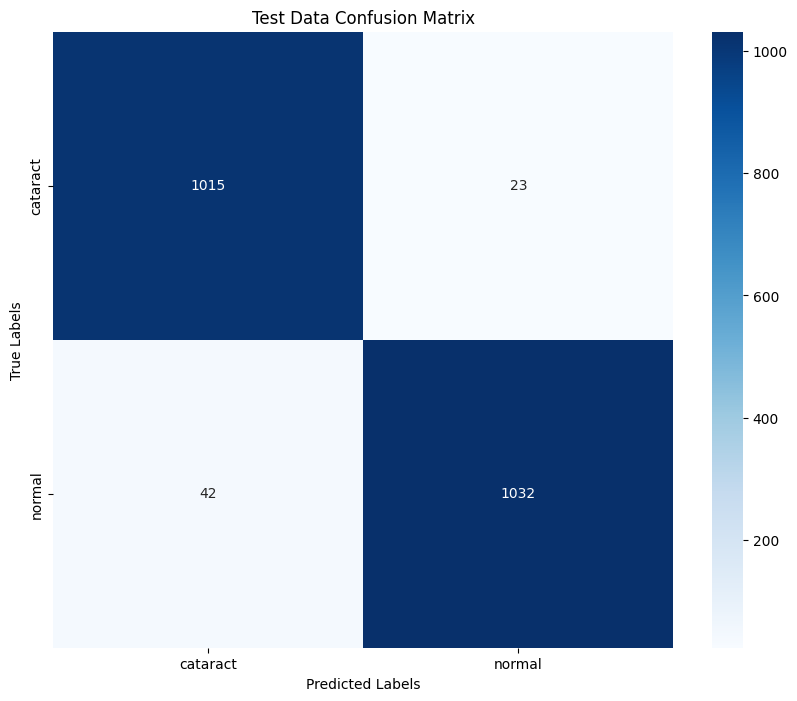

In [7]:
# Data testing
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    directory='dataset2',
    target_size=(150, 150),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

# Predicting the test data
Y_pred_test = model.predict(test_generator, len(test_generator))
y_pred_test = np.argmax(Y_pred_test, axis=1)

# True labels from test generator
y_true_test = test_generator.classes

# Classification report and confusion matrix
print('Classification Report')
target_names = list(test_generator.class_indices.keys())
print(classification_report(y_true_test, y_pred_test, target_names=target_names))

print('Confusion Matrix')
conf_matrix_test = confusion_matrix(y_true_test, y_pred_test)
print(conf_matrix_test)

# Plotting the confusion matrix
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Test Data Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

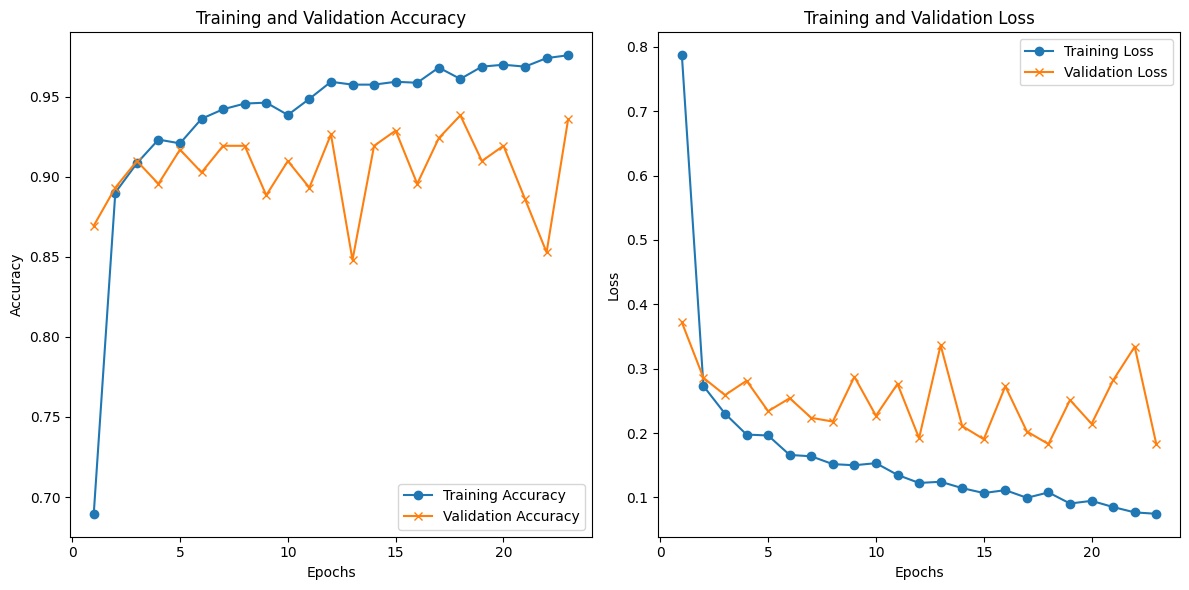

In [8]:
# Plotting accuracy and loss for training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='x')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='x')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()